このNotebookは、モデルを学習させるために作られたものである。

# 1. Configuration

In [188]:
# Run Configuration
NOTEBOOK_NAME = "swin-s-base-512x16"
SAVE_DIR = "../results/" + NOTEBOOK_NAME
TEST_RUN = True
DEVICE = 'cuda'

# Weights & Biases Configuration
USE_WANDB = False
WANDB_INIT = {
    'project': 'RSNA-IAD',
    'group': 'Image Classification',
    'job_type': 'training_Swin_s',
}
ARTIFACT = {
    'name': NOTEBOOK_NAME,
    'type': 'loss & time',
}

# Input Data Configuration
IMAGE_SIZE = 256
NUM_SLICES = 16
BATCH_SIZE = 5
NUM_EPOCHS = 20
LABEL_NAMES = [
    # 13 classes
    'Left Infraclinoid Internal Carotid Artery',
    'Right Infraclinoid Internal Carotid Artery',
    'Left Supraclinoid Internal Carotid Artery',
    'Right Supraclinoid Internal Carotid Artery',
    'Left Middle Cerebral Artery',
    'Right Middle Cerebral Artery',
    'Anterior Communicating Artery',
    'Left Anterior Cerebral Artery',
    'Right Anterior Cerebral Artery',
    'Left Posterior Communicating Artery',
    'Right Posterior Communicating Artery',
    'Basilar Tip',
    'Other Posterior Circulation',
    # 'Aneurysm Present',
]


In [189]:
class Configuration:
    
    notebook_name = NOTEBOOK_NAME
    save_dir = SAVE_DIR
    test_run = TEST_RUN
    device = DEVICE
    use_wandb = USE_WANDB
    wandb_init = WANDB_INIT
    artifact = ARTIFACT
    image_size = IMAGE_SIZE
    num_slices = NUM_SLICES
    batch_size = BATCH_SIZE
    num_epochs = NUM_EPOCHS
    label_names = LABEL_NAMES

CFG = Configuration


# 2. Import

In [190]:
import os
import random
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path
from collections import defaultdict
from typing import List, Dict, Optional, Tuple
from IPython.display import display
import datetime
import time
from tqdm.notebook import tqdm

# Data handling
import numpy as np
import polars as pl
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from skmultilearn.model_selection import iterative_train_test_split

# Medical imaging
import pydicom
import cv2

# Machine Lerning 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.amp import autocast
import torchvision
import timm

# Transformations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import PIL.Image as Image

# Experiment Management
import wandb

# Competition API
# import kaggle_evaluation.rsna_inference_server


In [191]:
# datetime for unique checkpoint filenames
date_time = datetime.datetime.now()
date_time = date_time.strftime('%Y-%m-%d_%H-%M-%S')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [192]:
def set_random_seeds(seed=42, deterministic=False):

    """
    Set random seed.
    
    Args:
        seed (int): Seed to be used.
        deterministic (bool): Whether to set the deterministic option for
            CUDNN backend, i.e., set `torch.backends.cudnn.deterministic`
            to True and `torch.backends.cudnn.benchmark` to False.
            Default: False.
    """
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
    if deterministic:
        torch.backends.cudnn.benchmark = True

set_random_seeds(seed=42)


# 3. Weights & Biases

In [193]:
if CFG.use_wandb:

    os.environ['WANDB_NOTEBOOK_NAME'] = CFG['notebook_name']
    wandb.login()
    run = wandb.init(**CFG.wandb_init)
    artifact = wandb.Artifact(**CFG.artifact)

else:
    
    run = None
    artifact = None


In [194]:
def alert_by_wandb(title='', text=''):
    wandb.alert(title, text)


# 4. Model

In [195]:
model = torchvision.models.swin_s(pretrained=False, num_classes=13)
model


SwinTransformer(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): Permute()
      (2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (1): Sequential(
      (0): SwinTransformerBlock(
        (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (attn): ShiftedWindowAttention(
          (qkv): Linear(in_features=96, out_features=288, bias=True)
          (proj): Linear(in_features=96, out_features=96, bias=True)
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (0): Linear(in_features=96, out_features=384, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=384, out_features=96, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (1): SwinTransformerBlock(
       

In [196]:
# Model
model = torchvision.models.swin_s(pretrained=False, num_classes=13)
model.features[0][0] = nn.Conv2d(
    in_channels=CFG.num_slices,
    out_channels=96,
    kernel_size=4,
    stride=4,
    padding=0
)
model.to(device)

# Optimizer
optimizer = torch.optim.AdamW(model.parameters())

# Loss Function
criterion = nn.BCEWithLogitsLoss()

# Scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=CFG.num_epochs
)


In [197]:
model


SwinTransformer(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(16, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): Permute()
      (2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (1): Sequential(
      (0): SwinTransformerBlock(
        (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (attn): ShiftedWindowAttention(
          (qkv): Linear(in_features=96, out_features=288, bias=True)
          (proj): Linear(in_features=96, out_features=96, bias=True)
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (0): Linear(in_features=96, out_features=384, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=384, out_features=96, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (1): SwinTransformerBlock(
      

In [198]:
is_in_cuda_list = []

for name, parameter in model.named_parameters():
    # determination of cuda and its storage
    is_in_cuda_list.append(parameter.is_cuda)
    
if all(is_in_cuda_list):
    print('All parameters is in cuda')
        
else:
    print('One of the parameters is not in the cuda.')


All parameters is in cuda


# 5. Dataset

In [199]:
series_list = os.listdir(f'../series_npy/{CFG.image_size}')
image_path_df = pd.read_csv(f'../npy_path/image_{CFG.image_size}_path_df.csv')
label_df = pd.read_csv(f'../train.csv')
label_df = label_df[['SeriesInstanceUID'] + CFG.label_names]
label_df


,SeriesInstanceUID,Left Infraclinoid Internal Carotid Artery,Right Infraclinoid Internal Carotid Artery,Left Supraclinoid Internal Carotid Artery,Right Supraclinoid Internal Carotid Artery,Left Middle Cerebral Artery,Right Middle Cerebral Artery,Anterior Communicating Artery,Left Anterior Cerebral Artery,Right Anterior Cerebral Artery,Left Posterior Communicating Artery,Right Posterior Communicating Artery,Basilar Tip,Other Posterior Circulation
0,1.2.826.0.1.3680043.8.498.10004044428023505108...,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.2.826.0.1.3680043.8.498.10004684224894397679...,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.2.826.0.1.3680043.8.498.10005158603912009425...,0,0,0,0,0,0,0,0,0,0,0,0,1
3,1.2.826.0.1.3680043.8.498.10009383108068795488...,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.2.826.0.1.3680043.8.498.10012790035410518400...,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4343,1.2.826.0.1.3680043.8.498.99915610493694667606...,0,0,0,0,0,0,0,0,0,0,0,0,0
4344,1.2.826.0.1.3680043.8.498.99920680741054836990...,0,0,0,0,0,0,0,0,0,0,0,0,0
4345,1.2.826.0.1.3680043.8.498.99953513260518059135...,0,0,0,0,0,0,0,0,0,0,0,0,0
4346,1.2.826.0.1.3680043.8.498.99982144859397209076...,0,0,0,0,0,0,0,0,0,0,0,0,0


In [200]:
# for training
train_transform = A.Compose(
    [   
        # A.Compose([  # Original
        #     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        #     ToTensorV2()
        # ]),
        # A.Compose([  # Horizontal flip
        #     A.HorizontalFlip(p=0.5),
        #     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        #     ToTensorV2()
        # ]),
        # A.Compose([  # Vertical flip
        #     A.VerticalFlip(p=0.5),
        #     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        #     ToTensorV2()
        # ]),
        # A.Compose([  # 90 degree rotation
        #     A.RandomRotate90(p=0.5),
        #     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        #     ToTensorV2()
        # ])
        
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        # ToTensorV2(),
        
        # Horizontal Flip
        A.HorizontalFlip(p=0.5),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        # ToTensorV2(),
        
        # Vertical flip
        A.VerticalFlip(p=0.5),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        # ToTensorV2(),
        
        # 90 degree rotation
        A.RandomRotate90(p=0.5),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        # ToTensorV2(),
        
        # ↓Original
        # Sharpen
        A.Sharpen(alpha=(0, 1.0), p=0.5),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),        
        ToTensorV2(),
    ]
)

# for inference
inference_transform = A.Compose(
    [
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ]
)
    
# for TTA
tta_transform = A.Compose(
    [
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            
        # Horizontal flip
        A.HorizontalFlip(p=1.0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        
        # Vertical flip
        A.VerticalFlip(p=1.0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        
        # 90 degree rotation
        A.RandomRotate90(p=1.0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        
        # ↓ Original
        # Sharpen
        A.Sharpen(alpha=(0, 1.0), p=1.0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        
        ToTensorV2(),
    ]
)


In [201]:
class BaseDataset(torch.utils.data.Dataset):
    '''
    Datasetの__getitem__()は、num_slicesの枚数分だけ画像を出力する。
    
    Arguments:
    - series_list: 画像のSeriesInstanceUIDのリスト
    - image_path_df: 画像のパスを含むDataFrame
    - label_df: ラベルが入ったDataFrame
    - num_slices: 1つのシリーズから抽出するスライス数
    - transforms: 画像変換のためのAlbumentationsのComposeオブジェクト
    '''
    def __init__(self,
                 series_list: list,
                 image_path_df: pd.DataFrame,
                 label_df: pd.DataFrame,
                 transforms=None
        ):
        self.series_list = series_list
        self.image_path_df = image_path_df
        self.label_df = label_df
        self.transforms = transforms
        self.num_slices = CFG.num_slices

    def __len__(self):
        return len(self.series_list)

    def __getitem__(self, index):
        # Index to SeriesInstanceUID
        series_id = self.series_list[index]
        print('series_id:', series_id)
        # SeriesInstanceUID to Image Path
        image_path_df = self.image_path_df[
            self.image_path_df['series_id'] == series_id
        ].reset_index(drop=True)
        
        # Load Images
        indices = np.linspace(0,
                              len(image_path_df) - 1,
                              self.num_slices).astype(np.int32)
        images = []
        for i in indices:
            image_path = image_path_df.loc[i, 'npy_path']
            image = np.load(image_path).astype(np.uint8)
            images.append(image)
        images = np.stack(images, axis=-1)
        
        # Transform
        if self.transforms:
            # ToTensorV2はnumpy.ndarrayをtorch.Tensorに変換する
            augmented = self.transforms(image=images)
            images = augmented['image']
            
        else:
            images = torch.tensor(images, dtype=torch.float32)

        # Labels
        labels = self.label_df.loc[series_id, CFG.label_names].values
        labels = torch.tensor(labels, dtype=torch.float32)
        
        return (images, labels)


# 6. DataLoader

In [202]:
def build_dataloaders():

    series = label_df[["SeriesInstanceUID"]].values
    labels = label_df[CFG.label_names].values

    if CFG.test_run:
        # As the absolute number of data points cannot be specified,
        # split is executed in two stages.
        train_series, train_labels, val_series, _ = iterative_train_test_split(
            series, labels, test_size=(1/len(series)) \
                * 2
        )
        _, _, train_series, train_labels = iterative_train_test_split(
            train_series, train_labels, test_size=(1/len(series)) \
                * 2
        )
        
    else:
        train_series, train_labels, val_series, val_labels = iterative_train_test_split(
            series, labels, test_size=0.2
        )

    # 2 dimensions -> 1 dimension
    train_series, val_series = train_series.flatten(), val_series.flatten()
    print(f"Train size: {len(train_series)}, Val size: {len(val_series)}")

    train_image_path_df = \
        image_path_df[image_path_df['series_id'] \
        .isin(train_series)].reset_index(drop=True)
    val_image_path_df = \
        image_path_df[image_path_df['series_id'] \
        .isin(val_series)].reset_index(drop=True)
        
    train_label_df = label_df[label_df['SeriesInstanceUID']
        .isin(train_series)].set_index('SeriesInstanceUID')
    val_label_df = label_df[label_df['SeriesInstanceUID']
        .isin(val_series)].set_index('SeriesInstanceUID')

    train_dataset = BaseDataset(
        series_list=train_series,
        image_path_df=train_image_path_df,
        label_df=train_label_df,
        transforms=train_transform
    )
    val_dataset = BaseDataset(
        series_list=val_series,
        image_path_df=val_image_path_df,
        label_df=val_label_df,
        transforms=train_transform # tta_transform
    )
    train_dataloader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=CFG.batch_size,
        shuffle=True,
        num_workers=0
    )
    val_dataloader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=CFG.batch_size,
        shuffle=False,
        num_workers=0
    )

    return train_dataset, train_dataloader, val_dataloader


In [203]:
train_dataset, train_dataloader, val_dataloader = build_dataloaders()


Train size: 2, Val size: 2


1.2.826.0.1.3680043.8.498.10004044428023505108375152878107656647
image: (256, 256)


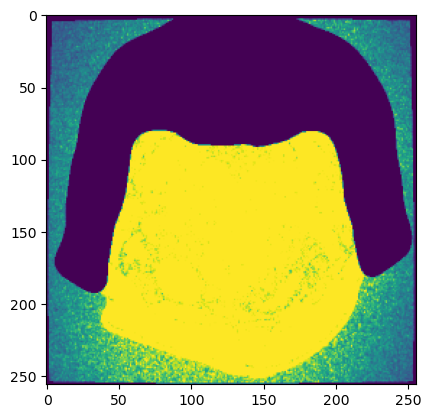

In [204]:
# ↓ この画像と同じものがDatasetから取り出せるか確認
print(series_list[0])
image = np.load(f'../series_npy/{CFG.image_size}/1.2.826.0.1.3680043.8.498.10023411164590664678534044036963716636/00001.npy')
print('image:', image.shape)
plt.imshow(image)


series_id: 1.2.826.0.1.3680043.8.498.99915610493694667606317602915236740051
torch.Size([16, 256, 256])
[-2.1548045 -2.1548042 -2.154804 ]
shape: (256, 256)
unique: [-2.1548045 -2.1548042 -2.154804 ]


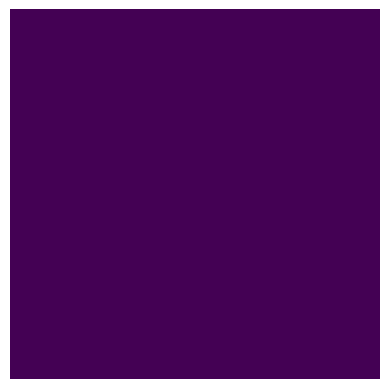

In [205]:
images, _ = train_dataset[0]
print(images.shape)
print(np.unique(images))

# 0番目のスライスを選択
img = images[10]  # shape: [H, W]

img = img.numpy()

print('shape:', img.shape)
print('unique:', np.unique(img))

# 0-1のfloatなら0-255に変換
if img.max() <= 1.0:
    img = (img * 255).astype(np.uint8)
else:
    img = img.astype(np.uint8)

# PILで表示
# pil_img = Image.fromarray(img)
plt.imshow(img)
plt.axis('off')
plt.show()


In [206]:
images = train_dataset[0][0].numpy()
print(images.shape)
images = np.transpose(images, (1, 2, 0))[:, :, 1]
print(images.shape)
image = Image.fromarray(images)
image


series_id: 1.2.826.0.1.3680043.8.498.99915610493694667606317602915236740051
(16, 256, 256)
(256, 256)


<PIL.Image.Image image mode=F size=256x256>

In [207]:
# train_image_path_df.head()


In [208]:
# val_image_path_df.head()


# 7. Functions

In [209]:
# count execution time for one epoch
def count_time(start:float) -> str:
    
    elapsed_time = time.time() - start
    hour = str(int(elapsed_time // 3600)).zfill(2)
    minute = str(int((elapsed_time % 3600) // 60)).zfill(2)
    second = str(int((elapsed_time % 3600 % 60))).zfill(2)
    
    elapsed_time = f'{hour}:{minute}:{second}'
    
    return elapsed_time


In [210]:
# to save model, optimizer, scheduler
def save_checkpoint(model, optimizer, scheduler, path=""):
    
    path = path.replace('\\', '/')
    
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict() if scheduler is not None else None,
    }
    torch.save(checkpoint, path)

# to load model, optimizer, scheduler
def load_checkpoint(model, optimizer, scheduler, path=""):
    
    path = path.replace('\\', '/')
    
    checkpoint = torch.load(path)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if scheduler is not None and checkpoint['scheduler_state_dict'] is not None:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    
    return model, optimizer, scheduler


In [211]:
# to log loss, metrics, time to W&B
def log_by_wandb(epoch, losses, time):
    
    epoch_data = {
        'epoch': epoch,
        'loss': losses,
        'time': time
    }
    
    wandb.log(epoch_data)


In [212]:
# to log checkpoint
def log_artifact(run=run, artifact=artifact, checkpoint_path=""):
    
    artifact.add_file(checkpoint_path)
    run.log_artifact(artifact)
    
    print('Artifact was logged to W&B')


# 7. Training

In [213]:
def train_one_epoch(epoch: int) -> Tuple[float, float]:
    
    print(f'----- Epoch {epoch + 1} -----')
    
    # Training
    train_losses = []
    model.train()
    
    for images, labels in tqdm(train_dataloader):    
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        with autocast(device_type=CFG.device):
            print('train:', images.shape)
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
    
    mean_train_loss = np.mean(train_losses)
    print(f'Mean Train Loss: {mean_train_loss:.4f}')
    
    # Validation
    val_losses = []
    model.eval()
    
    with torch.no_grad():
        for images, labels in tqdm(val_dataloader):
            images = images.to(device)
            labels = labels.to(device)
            with autocast(device_type=CFG.device):
                print('val:', images.shape)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_losses.append(loss.item())
        
    mean_val_loss = np.mean(val_losses)
    print(f'Mean Validation Loss: {mean_val_loss:.4f}')
        
    scheduler.step()
        
    return mean_train_loss, mean_val_loss


In [214]:
def main():
    
    os.makedirs(CFG.save_dir, exist_ok=True)
    best_val_loss = np.inf
    
    for epoch in range(CFG.num_epochs):
        
        # Train & Validation
        start_time = time.time()
        train_loss, val_loss = train_one_epoch(epoch)
        elapsed_time = count_time(start_time)
        print(f'Elapsed time: {elapsed_time}')
        
        # Log to W&B
        if CFG.use_wandb:
            losses = {
                'train_loss': train_loss,
                'val_loss': val_loss
            }
            log_by_wandb(epoch + 1, losses, elapsed_time)
        
        # Save all checkpoints
        checkpoint_path = os.path.join(
            CFG.save_dir,
            f'checkpoint_epoch{epoch + 1}_{date_time}.pth'
        )
        save_checkpoint(model, optimizer, scheduler, checkpoint_path)
        print(f'Checkpoint saved at {checkpoint_path}')
        
        # Save best checkpoint
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_checkpoint_path = os.path.join(
                CFG.save_dir,
                f'best_checkpoint_{date_time}.pth'
            )
            save_checkpoint(model, optimizer, scheduler, best_checkpoint_path)
            print(f'Best checkpoint updated at {best_checkpoint_path}')
    
    # Log artifact to W&B
    if CFG.use_wandb:
        log_artifact(run, artifact, best_checkpoint_path)


In [ ]:
main()


----- Epoch 1 -----


  0%|          | 0/1 [00:00<?, ?it/s]

series_id: 1.2.826.0.1.3680043.8.498.99915610493694667606317602915236740051
series_id: 1.2.826.0.1.3680043.8.498.99953513260518059135058337324142717073
train: torch.Size([2, 16, 256, 256])
Mean Train Loss: 0.7693


  0%|          | 0/1 [00:00<?, ?it/s]

series_id: 1.2.826.0.1.3680043.8.498.99920680741054836990188220871756333156
series_id: 1.2.826.0.1.3680043.8.498.99982144859397209076137275088962041066
val: torch.Size([2, 16, 256, 256])
Mean Validation Loss: 0.0822
Elapsed time: 00:00:01
Checkpoint saved at ../results/swin-s-base-512x16\checkpoint_epoch1_2025-09-23_12-24-13.pth
Best checkpoint updated at ../results/swin-s-base-512x16\best_checkpoint_2025-09-23_12-24-13.pth
----- Epoch 2 -----


  0%|          | 0/1 [00:00<?, ?it/s]

series_id: 1.2.826.0.1.3680043.8.498.99915610493694667606317602915236740051
series_id: 1.2.826.0.1.3680043.8.498.99953513260518059135058337324142717073
train: torch.Size([2, 16, 256, 256])
Mean Train Loss: 0.0819


  0%|          | 0/1 [00:00<?, ?it/s]

series_id: 1.2.826.0.1.3680043.8.498.99920680741054836990188220871756333156
series_id: 1.2.826.0.1.3680043.8.498.99982144859397209076137275088962041066
val: torch.Size([2, 16, 256, 256])
Mean Validation Loss: 0.0211
Elapsed time: 00:00:00
Checkpoint saved at ../results/swin-s-base-512x16\checkpoint_epoch2_2025-09-23_12-24-13.pth
Best checkpoint updated at ../results/swin-s-base-512x16\best_checkpoint_2025-09-23_12-24-13.pth
----- Epoch 3 -----


  0%|          | 0/1 [00:00<?, ?it/s]

series_id: 1.2.826.0.1.3680043.8.498.99915610493694667606317602915236740051
series_id: 1.2.826.0.1.3680043.8.498.99953513260518059135058337324142717073
train: torch.Size([2, 16, 256, 256])
Mean Train Loss: 0.0207


  0%|          | 0/1 [00:00<?, ?it/s]

series_id: 1.2.826.0.1.3680043.8.498.99920680741054836990188220871756333156
series_id: 1.2.826.0.1.3680043.8.498.99982144859397209076137275088962041066
val: torch.Size([2, 16, 256, 256])
Mean Validation Loss: 0.0156
Elapsed time: 00:00:00
Checkpoint saved at ../results/swin-s-base-512x16\checkpoint_epoch3_2025-09-23_12-24-13.pth
Best checkpoint updated at ../results/swin-s-base-512x16\best_checkpoint_2025-09-23_12-24-13.pth
----- Epoch 4 -----


  0%|          | 0/1 [00:00<?, ?it/s]

series_id: 1.2.826.0.1.3680043.8.498.99953513260518059135058337324142717073
series_id: 1.2.826.0.1.3680043.8.498.99915610493694667606317602915236740051
train: torch.Size([2, 16, 256, 256])
Mean Train Loss: 0.0186


  0%|          | 0/1 [00:00<?, ?it/s]

series_id: 1.2.826.0.1.3680043.8.498.99920680741054836990188220871756333156
series_id: 1.2.826.0.1.3680043.8.498.99982144859397209076137275088962041066
val: torch.Size([2, 16, 256, 256])
Mean Validation Loss: 0.0118
Elapsed time: 00:00:00
Checkpoint saved at ../results/swin-s-base-512x16\checkpoint_epoch4_2025-09-23_12-24-13.pth
Best checkpoint updated at ../results/swin-s-base-512x16\best_checkpoint_2025-09-23_12-24-13.pth
----- Epoch 5 -----


  0%|          | 0/1 [00:00<?, ?it/s]

series_id: 1.2.826.0.1.3680043.8.498.99915610493694667606317602915236740051
series_id: 1.2.826.0.1.3680043.8.498.99953513260518059135058337324142717073
train: torch.Size([2, 16, 256, 256])
Mean Train Loss: 0.0119


  0%|          | 0/1 [00:00<?, ?it/s]

series_id: 1.2.826.0.1.3680043.8.498.99920680741054836990188220871756333156
series_id: 1.2.826.0.1.3680043.8.498.99982144859397209076137275088962041066
val: torch.Size([2, 16, 256, 256])
Mean Validation Loss: 0.0093
Elapsed time: 00:00:00
Checkpoint saved at ../results/swin-s-base-512x16\checkpoint_epoch5_2025-09-23_12-24-13.pth
Best checkpoint updated at ../results/swin-s-base-512x16\best_checkpoint_2025-09-23_12-24-13.pth
----- Epoch 6 -----


  0%|          | 0/1 [00:00<?, ?it/s]

series_id: 1.2.826.0.1.3680043.8.498.99953513260518059135058337324142717073
series_id: 1.2.826.0.1.3680043.8.498.99915610493694667606317602915236740051
train: torch.Size([2, 16, 256, 256])
Mean Train Loss: 0.0094


  0%|          | 0/1 [00:00<?, ?it/s]

series_id: 1.2.826.0.1.3680043.8.498.99920680741054836990188220871756333156
series_id: 1.2.826.0.1.3680043.8.498.99982144859397209076137275088962041066
val: torch.Size([2, 16, 256, 256])
Mean Validation Loss: 0.0076
Elapsed time: 00:00:00
Checkpoint saved at ../results/swin-s-base-512x16\checkpoint_epoch6_2025-09-23_12-24-13.pth


In [ ]:
datetime


<module 'datetime' from 'c:\\Users\\emanon\\anaconda3\\envs\\Kaggle\\Lib\\datetime.py'>

stacked: (16, 256, 256)  
transformed: torch.Size([256, 16, 256])  
permuted: torch.Size([256, 256, 16])  
train: torch.Size([1, 256, 256, 16])  

stacked: (16, 256, 256)  
transformed: torch.Size([256, 16, 256])  
permuted: torch.Size([256, 256, 16])  
train: torch.Size([1, 256, 256, 16])  


stacked: (16, 256, 256)  
transformed: torch.Size([256, 256, 16])  
permuted: torch.Size([16, 256, 256])  
train: torch.Size([1, 16, 256, 256])  

stacked: (16, 256, 256)  
transformed: torch.Size([256, 16, 256])  
permuted: torch.Size([256, 256, 16])  
train: torch.Size([1, 256, 256, 16])  